In [1]:
from scipy.optimize import fsolve
import numpy as np

In [2]:
# constante 
g = 9.80665

rho = 1.225

V = 7

m_dirigeable = 3
m_mot = 0.142
m_ballaste = 1
m_nacelle = 0.75

m_tot = m_dirigeable + 4 * m_mot + m_ballaste + m_nacelle

Moment d'inertie pour un corps semblable à une ellipsoïde
$$I_i = 0.2* m_{dirigeable} * (j^{2} + k^{2})$$

In [3]:
# expression des moments d'inerties
a = 3
b = 0.75 
c = 0.75

I_x = (1/5) * m_dirigeable * (np.square(b) + np.square(c))
I_y = (1/5) * m_dirigeable * (np.square(a) + np.square(c))
I_z = (1/5) * m_dirigeable * (np.square(a) + np.square(b))

I = {
    'I_x': I_x,
    'I_y': I_y,
    'I_z': I_z
}

In [4]:
# calcul des distances entre les composants et le centre de gravité

CG_dir = np.array([0.39706, 0, -0.098039])
CG_AvD = np.array([2, 0.8, 0])
CG_AvG = np.array([2, -0.8, 0])
CG_ArD = np.array([-2, 0.8, 0])
CG_ArG = np.array([-2, -0.8, 0])
CG_Nac = np.array([0, 0, -0.8])

CG_struct = {
    'CG_AvD': CG_AvD,
    'CG_AvG': CG_AvG,
    'CG_ArD': CG_ArD,
    'CG_ArG': CG_ArG,
    'CG_Nac': CG_Nac
}

d_AvD_GC = np.linalg.norm(CG_dir - CG_AvD)
d_AvG_GC = np.linalg.norm(CG_dir - CG_AvG)
d_ArD_GC = np.linalg.norm(CG_dir - CG_ArD)
d_ArG_GC = np.linalg.norm(CG_dir - CG_ArG)
d_Nac_GC = np.linalg.norm(CG_dir - CG_Nac)

distance = {
    'd_AvD_GC': d_AvD_GC,
    'd_AvG_GC': d_AvG_GC,
    'd_ArD_GC': d_ArD_GC,
    'd_ArG_GC': d_ArG_GC,
    'd_Nac_GC': d_Nac_GC
}

In [5]:
# calcul des forces et moments des moteurs

ang_1, ang_2, ang_3, ang_4 = np.radians(45), np.radians(0), np.radians(0), np.radians(0)

def thrust_norm(V) -> float:
    return 0.048*np.square(V) - 0.011 * V + 0.009

angle = {
    'alpha_1': ang_1,
    'alpha_2': ang_2,
    'alpha_3': ang_3,
    'alpha_4': ang_4
}

euler_angle = {
    "phi": np.radians(0),
    'theta': np.radians(0),
    'psi': np.radians(0)
}

f_mot = thrust_norm(V=5.0)

fx = np.array([f_mot * np.cos(alpha) for alpha in angle.values()])
fz = np.array([f_mot * np.sin(alpha) for alpha in angle.values()])

M = np.array([np.cross(CG_dir - CG, [Fx, 0, Fz]) for CG, Fx, Fz in zip(CG_struct.values(), fx, fz)])

(500,)


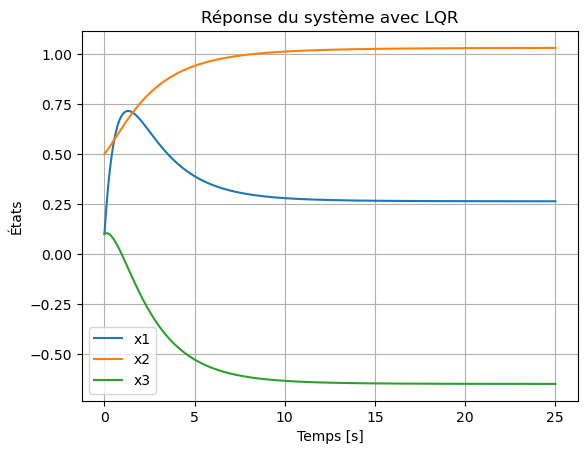

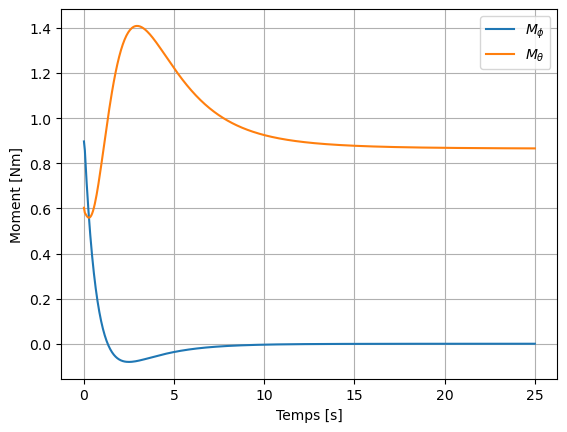

In [6]:
import numpy as np
from scipy.linalg import solve_continuous_are
from scipy.signal import StateSpace, lsim
import matplotlib.pyplot as plt

X_0 = np.array([0.1, 0.5, 0.1])

A = np.array([
    [0, X_0[2] * (I['I_y'] - I['I_z'])/I['I_x'], X_0[1] * (I['I_y'] - I['I_z'])/I['I_x']],
    [X_0[2] * (I['I_z'] - I['I_x'])/I['I_y'], 0, X_0[0] * (I['I_z'] - I['I_x'])/I['I_y']],
    [X_0[1] * (I['I_x'] - I['I_y'])/I['I_z'], X_0[0] * (I['I_x'] - I['I_y'])/I['I_z'], 0]
])

B = np.diag([1/I['I_x'], 1/I['I_y'], 1/I['I_z']])

C = np.array([
    [1, 0, 0],
    [0, 1, 0]
])

# Matrices de pondération pour LQR
Q = np.eye(3)  # Pondération des états
R = np.eye(3)  # Pondération des commandes

# Résoudre l'équation de Riccati continue
P = solve_continuous_are(A, B, Q, R)

# Calculer le gain LQR
K = np.linalg.inv(R) @ B.T @ P

# Simuler le système en boucle fermée
def simulate_system(A, B, K, X0, T):
    A_cl = A - B @ K
    system = StateSpace(A_cl, B, C, np.zeros((2, 3)))
    T, yout, xout = lsim(system, U=np.ones((len(T), 3)), T=T, X0=X0)
    print(T.shape)
    return T, xout

# Temps de simulation
T = np.linspace(0, 25, 500)

# Simuler le système
T, xout = simulate_system(A, B, K, X_0, T)

# Afficher les résultats
plt.figure()
plt.plot(T, xout[:, 0], label='x1')
plt.plot(T, xout[:, 1], label='x2')
plt.plot(T, xout[:, 2], label='x3')
plt.xlabel('Temps [s]')
plt.ylabel('États')
plt.legend()
plt.title('Réponse du système avec LQR')
plt.grid()
plt.show()

# Différencier numériquement les états pour obtenir dp/dt, dq/dt, dr/dt
dp_dt = np.gradient(xout[:, 0], T)
dq_dt = np.gradient(xout[:, 1], T)
dr_dt = np.gradient(xout[:, 2], T)

# Extraire les valeurs de p, q, r
p = xout[:, 0]
q = xout[:, 1]
r = xout[:, 2]

# Calculer M_roulis
M_roulis = I_x * dp_dt + (I_z - I_y) * q * r

# Calculer M_tangage
M_tangage = I_y * dq_dt + (I_x - I_z) * p * r

# Afficher les résultats pour M_roulis
plt.figure()
plt.plot(T, M_roulis, label=r'$M_{\phi}$')
plt.plot(T, M_tangage, label=r'$M_{\theta}$')
plt.xlabel('Temps [s]')
plt.ylabel('Moment [Nm]')
plt.legend()
plt.grid()
plt.show()

In [7]:
T_sim = np.linspace(0, 25, 500)

matrice = {
    'A': A,
    'B': B,
    'C': C,
    'D': np.zeros((2, 3)),
    'U': np.ones((len(T), 1))
}

I = {
    'I_x': I_x,
    'I_y': I_y,
    'I_z': I_z
}

X_0 = np.array([0.1, 0.1, 0.1])

data_dict = {
    'I': I,
    'mass': 3,
    'T_sim': T_sim
}


In [8]:
import FC_model

FC = FC_model.FlightControl(matrice, X_0, data_dict)


ERROR : System does not define that many inputs.
